In [7]:

import sys
!{sys.executable} -m pip install -U deepposekit




Requirement already up-to-date: deepposekit in /usr/local/lib/python3.6/dist-packages (0.3.9)


In [8]:
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
from deepposekit.io import VideoReader, DataGenerator, initialize_dataset,BaseGenerator, TrainingGenerator

from deepposekit.annotate import KMeansSampler
import tqdm
import glob
import pandas as pd

from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

In [5]:
!git clone https://github.com/jgraving/deepposekit-data {HOME + '/deepposekit-data'}

Cloning into './deepposekit-data'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 93 (delta 0), reused 7 (delta 0), pack-reused 86
Unpacking objects: 100% (93/93), done.
Checking out files: 100% (17/17), done.


In [6]:
from google.colab import files
uploaded=files.upload()

Saving dataset.zip to dataset.zip
Saving dataset.csv to dataset.csv


In [19]:
!ls

dataset  dataset.csv  dataset.zip  deepposekit-data  sample_data


In [9]:
class ToyGenerator(BaseGenerator):
    """
    ToyGenerator class 
    uses deepposekit.io.BaseGenerator for abstracting data loading and saving.
    Attributes that should be defined before use:
    __init__
    __len__
    compute_image_shape
    compute_keypoints_shape
    get_images
    get_keypoints
    set_keypoints (only needed for saving data)
    See docstrings for deepposekit.io.BaseGenerator for further details.
    """

    def __init__(self, images, keypoints, **kwargs):
        """
        Initializes the class.
        If graph and swap_index are not defined,
        they are set to a vector of -1 corresponding
        to keypoints shape
        """
        assert isinstance(images, np.ndarray)
        assert isinstance(keypoints, np.ndarray)
      
        self.images = images
        self.keypoints = keypoints
       # self.image_shape=(3840,2160,3)
        
        assert len(images) == len(keypoints)
        self.n_samples = len(images)
        
        # if the indexing for the real data doesn't match
        # np.arange(self.n_samples) you can customize it here
        self.data_index = np.arange(self.n_samples)
        
        # We'll use triangles as an example, so define the graph
        # -1 indicates that index is a parent node, other values >=0
        # indicate the parent for that node is the index value provided
        # Here we'll connect the two bottom points to the top
        # and avoid circular connections in the graph
        self.graph = np.array([-1, 0, 0])
        
        # You can define which keypoints to swap when the image
        # is mirrored with deepposekit.augment.FlipAxis
        # with a numpy array of index values.
        # -1 means no swap is made, but [2, 1, 0] would reverse the order
        # or [1, 0 ,2] would swap the first and second keypoints
        self.swap_index = np.array([-1, -1, -1])
            # basic checks to make sure the new generator will work
        super(ToyGenerator, self).__init__(**kwargs)
        
    def __len__(self):
        """
        Returns the number of samples in the generator as an integer
        """
        return self.n_samples
    
    def compute_image_shape(self):
        """
        Returns a tuple of integers describing
        the image shape in the form:
        (height, width, n_channels)
        """
        
        return self.images.shape[1:]
        
    def compute_keypoints_shape(self):
        """
        Returns a tuple of integers describing the
        keypoints shape in the form:
        (n_keypoints, 2), where 2 is the x,y (column, row) coordinates
        """
        return self.keypoints.shape[1:]

    def get_images(self, indexes):
        """
        Takes a list or array of indexes corresponding
        to image-keypoint pairs in the dataset.
        Returns a numpy array of images with the shape:
        (1, height, width, n_channels)
        """
        indexes = self.data_index[indexes]

        
        return self.images[indexes]
    
    def get_keypoints(self, indexes):
        """
        Takes a list or array of indexes corresponding to
        image-keypoint pairs in the dataset.
        Returns a numpy array of keypoints with the shape:
        (1, n_keypoints, 2), where 2 is the x,y (column, row) coordinates
        """
        indexes = self.data_index[indexes]
        return self.keypoints[indexes]
     
    def set_keypoints(self, indexes, keypoints):
        """
        Takes a list or array of indexes and corresponding
        to keypoints.
        Sets the values of the keypoints corresponding to the indexes
        in the dataset.
        """
        indexes = self.data_index[indexes]
        for idx in indexes:
            self.keypoints[idx] = keypoints[idx]   

In [10]:
import cv2,pandas as pd
data=pd.read_csv(HOME+'/dataset.csv')
print(data.iat[0,0])


def generate_random_triangle(index,image_size=(480, 480, 3)):
    keypoints=[]
    key=data.iloc[[index]]
    
    for i in range(1,7,2):
        x=(data.iat[index,i])/3840*480
        y=(data.iat[index,i+1])/2160*480
        id=(x,y)
        
        #print("id:",index,":",id)
        keypoints.append(id)
       # print('exac',keypoints)
    keypoints = np.stack(keypoints)   

    #print('shape',keypoints.shape)
    # generate random coordinates
    #x = np.random.uniform(0, image_size[1], size=3)
    #y = np.random.uniform(0, image_size[0], size=3)
   # print('keyidx',keypoints)
    # sort by y axis
    #sorted_idx = np.argsort(y)
    #x = x[sorted_idx]
    #y = y[sorted_idx]
    #keypoints = np.stack((x, y)).T
    
    # Generate a corresponding image with a random color
    #image = np.ones(image_size, dtype=np.uint8) * 255
    image=cv2.imread(HOME+'/dataset/'+str(index+1)+'.jpg')
   # image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,(480,480))
    image=image
    #print(image)
    

    #print(index)
   # print('xxx',keypoints)
    #color = tuple([np.random.randint(0, 255, dtype=int) for idx in range(image_size[-1])])
    #image = cv2.drawContours(image, [keypoints.reshape(3, 1, 2).astype(int)], 0, color, -1)

    return image, keypoints

def generator_toy_data(n_samples=40, image_size=(480, 480, 3)):
    images = []
    keypoints = []
    for idx in range(n_samples):
        image_idx, keypoints_idx = generate_random_triangle(idx,image_size)
        #print('keyidxshape',keypoints_idx.shape,'  imgidxshape',image_idx.shape)
        images.append(image_idx)
        keypoints.append(keypoints_idx)
       # print('keyidx',keypoints)
    images = np.stack(images)
    keypoints = np.stack(keypoints).astype(float)
    #print('xxxx',images[22])
   # print('final',images.shape)
    #print('final',keypoints.shape)

    return images, keypoints

FileNotFoundError: ignored

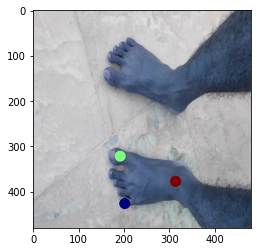

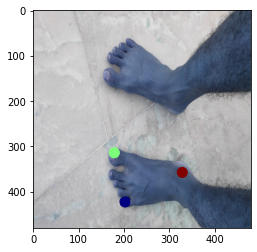

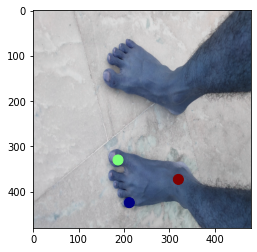

In [7]:
images, keypoints = generator_toy_data()
#print('keypoints',keypoints[0])


generator = ToyGenerator(images, keypoints)

for idx in range(3):
    image, keypoints = generator[idx]

    plt.imshow(image[0])
    plt.scatter(keypoints[0, ..., 0],
                keypoints[0, ..., 1],
                c=np.arange(3),
                s=100, cmap=plt.cm.jet, zorder=3)
    plt.show()







In [8]:

train_generator = TrainingGenerator(generator=generator,
                                    downsample_factor=3,
                                    augmenter=None,
                                    sigma=3,
                                    validation_split=0.1, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1
                                   )

#train_generator=TrainingGenerator(generator,validation_split=0.1)
train_generator.get_config()

{'augmenter': False,
 'downsample_factor': 3,
 'generator': 'ToyGenerator',
 'graph_scale': 1,
 'image_shape': (480, 480, 3),
 'keypoints_shape': (3, 2),
 'n_output_channels': 8,
 'n_samples': 40,
 'n_train': 36,
 'n_validation': 4,
 'output_shape': (60, 60),
 'output_sigma': 0.375,
 'random_seed': 1,
 'shuffle': True,
 'sigma': 3,
 'use_graph': True,
 'validation_split': 0.1}

In [9]:
from deepposekit.models import DeepLabCut, StackedDenseNet, StackedHourglass, LEAP

model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
#model = DeepLabCut(train_generator, backbone="resnet50")
#model = DeepLabCut(train_generator, backbone="mobilenetv2", alpha=0.35) # Increase alpha to improve accuracy
#model = DeepLabCut(train_generator, backbone="densenet121")

#model = LEAP(train_generator)
#model = StackedHourglass(train_generator)

model.get_config()

{'augmenter': False,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'downsample_factor': 3,
 'generator': 'ToyGenerator',
 'graph_scale': 1,
 'growth_rate': 32,
 'image_shape': (480, 480, 3),
 'keypoints_shape': (3, 2),
 'n_output_channels': 8,
 'n_samples': 40,
 'n_stacks': 2,
 'n_train': 36,
 'n_transitions': 5,
 'n_validation': 4,
 'name': 'StackedDenseNet',
 'output_shape': (60, 60),
 'output_sigma': 0.375,
 'pretrained': True,
 'random_seed': 1,
 'shuffle': True,
 'sigma': 3,
 'subpixel': True,
 'use_graph': True,
 'validation_split': 0.1}

(1, 60, 60, 8)


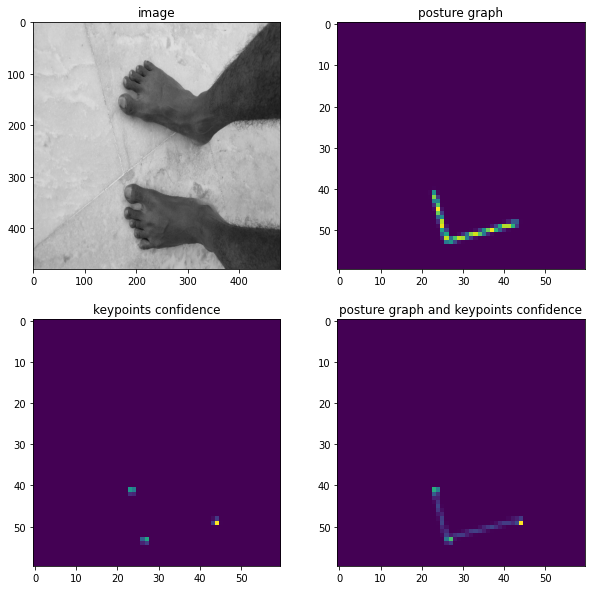

In [11]:
n_keypoints =3
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]
print(outputs.shape)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

In [12]:
from deepposekit.callbacks import Logger, ModelCheckpoint

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from deepposekit.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

logger = Logger(validation_batch_size=1,
    # filepath saves the logger data to a .h5 file
    # filepath=HOME + "/deepposekit-data/datasets/fly/log_densenet.h5"
)

In [13]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=1, patience=20)

In [14]:
model_checkpoint = ModelCheckpoint(
    HOME + "/deepposekit-data/datasets/fly/best_model_densenet.h5",
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    verbose=1,
    save_best_only=True,
)

In [15]:
early_stop = EarlyStopping(
    monitor="loss",
    # monitor="loss" # use if validation_split=0
    min_delta=0.001,
    patience=100,
    verbose=1
)


In [23]:
callbacks=[logger,reduce_lr,early_stop]
model.fit(
    batch_size=5,
    validation_batch_size=4,
    callbacks=[],
    #epochs=1000, # Increase the number of epochs to train the model longer
    epochs=20,
    n_workers=8,
    steps_per_epoch=None,
)

Epoch 1/20
7/7 [==============================] - 95s 14s/step - loss: 2.9981 - output_0_loss: 1.0314 - output_1_loss: 0.9848 - output_2_loss: 0.9818 - val_loss: 21.0331 - val_output_0_loss: 7.0964 - val_output_1_loss: 6.9689 - val_output_2_loss: 6.9678
Epoch 2/20
7/7 [==============================] - 95s 14s/step - loss: 2.6693 - output_0_loss: 0.9251 - output_1_loss: 0.8783 - output_2_loss: 0.8660 - val_loss: 21.5745 - val_output_0_loss: 7.2583 - val_output_1_loss: 7.1598 - val_output_2_loss: 7.1565
Epoch 3/20
7/7 [==============================] - 98s 14s/step - loss: 1.9655 - output_0_loss: 0.6688 - output_1_loss: 0.6503 - output_2_loss: 0.6464 - val_loss: 21.7388 - val_output_0_loss: 7.2958 - val_output_1_loss: 7.2093 - val_output_2_loss: 7.2337
Epoch 4/20
7/7 [==============================] - 95s 14s/step - loss: 2.1586 - output_0_loss: 0.7488 - output_1_loss: 0.7051 - output_2_loss: 0.7048 - val_loss: 21.3434 - val_output_0_loss: 7.2075 - val_output_1_loss: 7.0600 - val_output

In [93]:
model.save(HOME+'/footmodel.h5')





In [95]:
from google.colab import files
files.download(HOME+'/footmodel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [176]:
uploaded=files.upload()

Saving test.jpg to test.jpg


In [177]:
!ls

dataset      dataset.zip       footmodel.h5  test.jpg
dataset.csv  deepposekit-data  sample_data


In [1]:
image=cv2.imread(HOME+'/test.jpg')
image=cv2.resize(image,(480,480))
image=np.expand_dims(image, axis=0)
pred=model.predict(image)


NameError: ignored

In [2]:
x, y, confidence = np.split(pred, 3, -1)









images= image
keypoints= pred
#print('keypoints',keypoints[0])



for idx in range(3):
    

    plt.imshow(image[0])
    plt.scatter(keypoints[0, ..., 0],
                keypoints[0, ..., 1],
                c=np.arange(3),
                s=100, cmap=plt.cm.jet, zorder=3)
    plt.show()



NameError: ignored